In [1]:
import pandas as pd
import geopandas as gpd
import contextily
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from shapely.geometry import LineString
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

In [2]:
population = gpd.read_file('data/POPULATION_2023_SA2_GDA2020/32180_ERP_2023_SA2_GDA2020.gpkg')
population['geometry'] = population['geometry'].to_crs('EPSG:7855')

In [3]:
population = population.loc[population['GCCSA_name_2021'] == 'Greater Melbourne']
population['Pop_density_2023_people_per_km2'] += 1

In [4]:
metro = gpd.read_file('data/Metro Stops/PTV/PTV_METRO_TRAIN_STATION.shp')

In [5]:
def add_map_components(ax, bound, interval, arrow_pos=None):

    '''
        This function adds cartographic components on the map,
        including: Grid, Axes, Axes Label, North Arrow, Legends, Scale Bar
        It will be applied to every map later in the project
    '''
    # Add orientation arrow
    if arrow_pos == 'left':
        x, y, arrow_length = 0.08, 0.95, 0.1
    if arrow_pos == 'right':
        x, y, arrow_length = 0.92, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=3, headwidth=10),
                ha='center', va='center', fontsize=13, xycoords=ax.transAxes)
    
    # Add axis label
    ax.annotate('Northing', xy=(-0.2,0.45),
                fontsize=11, xycoords=ax.transAxes, rotation=90)
    ax.annotate('Easting', xy=(0.45,-0.12),
                fontsize=11, xycoords=ax.transAxes)
    
    # Remove unnecessary axis
    ax.set_axis_off()

    # Make some offest to avoid map touching boundary
    # Round to create whole number axis
    xmin, ymin, xmax, ymax = bound
    xmin = np.floor(xmin / interval - 0.4) * interval
    ymin = np.floor(ymin / interval - 0.4) * interval
    xmax = np.ceil(xmax / interval + 0.4) * interval
    ymax = np.ceil(ymax / interval + 0.4) * interval
    # Generate lines for graticule
    horizontal = np.arange(np.floor(ymin), np.ceil(ymax), interval)
    vertical = np.arange(np.floor(xmin), np.ceil(xmax), interval)

    # Plot horizontal lines
    for each in horizontal:
        line = LineString([(xmin, each), (xmax, each)])
        ax.annotate(f'{int(each)}', xy=(xmin+20000, each), xytext=(-60, -5),
                    textcoords="offset points")
        ax.plot(*line.xy, color='grey', linewidth=0.6, alpha=0.7)
    
    # Plot vertical lines
    for each in vertical:
        line = LineString([(each, ymin), (each, ymax)])
        ax.annotate(f'{int(each)}', xy=(each, ymin+10000), xytext=(-15, -35),
                    textcoords="offset points", rotation=45)
        ax.plot(*line.xy, color='grey', linewidth=0.6, alpha=0.7)

    # Add Scale Bar
    scalebar = ScaleBar(100, 'cm', 
                        length_fraction=0.15, 
                        location='lower right', 
                        frameon=True, 
                        color='black', 
                        scale_loc='bottom', label_loc='bottom', 
                        font_properties={'size': 12})
    
    ax.add_artist(scalebar)

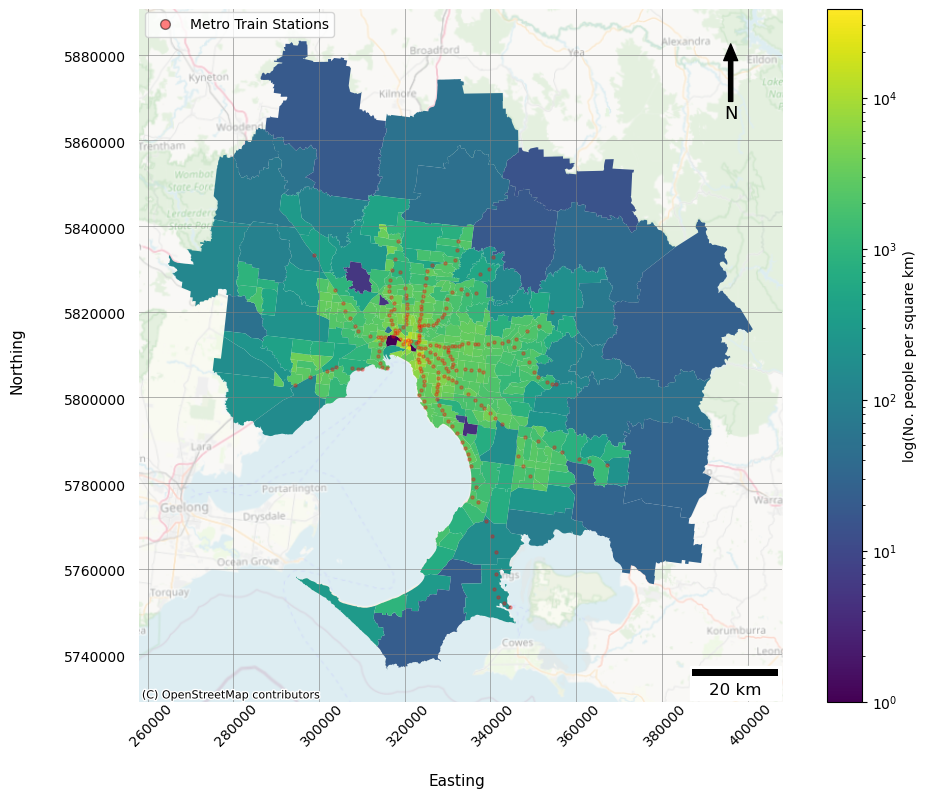

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
population.plot(column='Pop_density_2023_people_per_km2',
                ax=ax,
                legend=True,
                legend_kwds={'label': "log(No. people per square km)",'orientation': "vertical"},
                norm=LogNorm(vmin=population['Pop_density_2023_people_per_km2'].min(),
                              vmax=population['Pop_density_2023_people_per_km2'].max()))

metro.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.3) 
legend = [Line2D([0], [0], marker='o', 
                        color='r',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Metro Train Stations')]  
ax.legend(handles=legend, loc=(0.01,0.96))
contextily.add_basemap(ax=ax, 
                       crs = population.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.4)
add_map_components(ax, bound=population.total_bounds, interval=20000, arrow_pos='right')
#plt.title("Population Density of Greater Melbourne with Metro Train Stations")
plt.tight_layout()
plt.savefig('output/pop_density.png', dpi=300)
plt.show()

In [7]:
hospitals = pd.read_csv('data/hospitals.csv')[['Longitude', 'Latitude']]
schools = pd.read_csv('data/schools.csv')[['Longitude', 'Latitude']]
shopping = pd.read_csv('data/shopping_centre.csv')[['longitude', 'latitude']]
sport = pd.read_csv('data/sport_facilities.csv')[['Longitude', 'Latitude']]

shopping.columns = ['Longitude', 'Latitude']

In [8]:
facilities = pd.concat([hospitals, schools, shopping, sport])
facility_points = gpd.GeoDataFrame(
    facilities, 
    geometry=gpd.points_from_xy(facilities.Longitude, facilities.Latitude)
)
facility_points.crs = 'epsg:4326'
facility_points = facility_points.to_crs("EPSG:7855")


In [9]:
joined_df = gpd.sjoin(population, facility_points, how="left", op='intersects')
point_counts = joined_df.groupby('SA2_name_2021').size().reset_index(name='point_count')
df_final = population.merge(point_counts, on='SA2_name_2021', how='left')
df_final['point_count'].fillna(0, inplace=True) 
df_final['point_density'] = df_final['point_count'] / df_final['Area_km2']

c:\Users\Lenovo\anaconda3\envs\spanalytics\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34656\3976425718.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['point_count'].fillna(0, inplace=True)


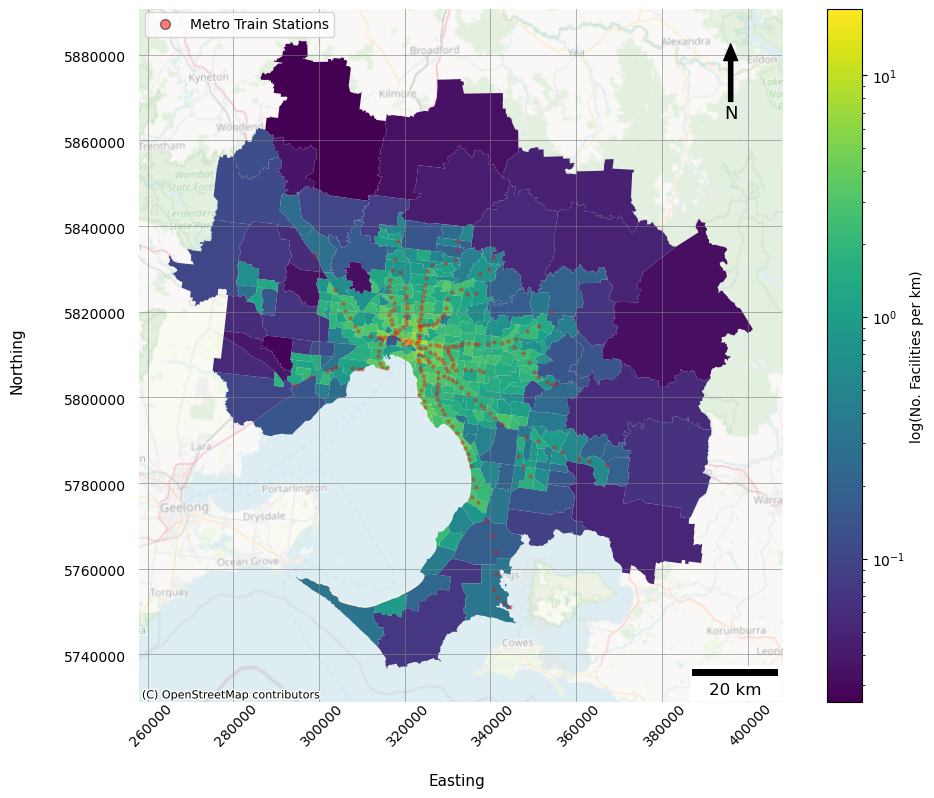

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
df_final.plot(column='point_density', ax=ax, legend=True,
              legend_kwds={'label': "log(No. Facilities per km)",
                           'orientation': "vertical"},
                           norm=LogNorm(vmin=df_final['point_density'].min(),
                              vmax=df_final['point_density'].max()))

metro.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.3) 
legend = [Line2D([0], [0], marker='o', 
                        color='r',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Metro Train Stations')]  
ax.legend(handles=legend, loc=(0.01,0.96))
contextily.add_basemap(ax=ax, 
                       crs = population.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.4)
add_map_components(ax, bound=population.total_bounds, interval=20000, arrow_pos='right')
#plt.title("Non-residential Facilitiy Density of Greater Melbourne with Metro Train Stations")
plt.tight_layout()
plt.savefig('output/facility_density.png', dpi=300)
plt.show()